# NLP Disaster Tweets — Overfitting Detection & Model Comparison

This notebook builds on the **NLP Disaster Tweets Kaggle mini-project**:

- Problem description & data overview  
- Exploratory Data Analysis (EDA) and data cleaning  
- Text preprocessing and word embeddings
- Train multiple **LSTM/GRU** models
- **Visualize** overfitting with training vs validation curves
- **Detect and quantify** overfitting via a simple metric
- **Compare** configurations in a results table

The goal is to **study model behavior**, detect when overfitting occurs, and learn which hyperparameters help.


In [3]:
# Cell 1: Imports and Paths
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks

print("TensorFlow version:", tf.__version__)

# Adjust here if data directory path is different
DATA_DIR = "data"
train_path = os.path.join(DATA_DIR, "train.csv")
test_path = os.path.join(DATA_DIR, "test.csv")
sample_sub_path = os.path.join(DATA_DIR, "sample_submission.csv")

TensorFlow version: 2.20.0


## 1. Problem Description & Data

We are given tweets and must predict whether a tweet is about a **real disaster (`target = 1`)** or **not (`target = 0`)**.
To get started the following is given:

**Files (under `data/`):**
- `train.csv` – features + labels  
- `test.csv` – features only  
- `sample_submission.csv` – Kaggle submission format  

**Columns:**
- `id` – unique tweet ID  
- `text` – tweet text  
- `keyword` – keyword from the tweet (may be blank)  
- `location` – location of the tweet (may be blank)  
- `target` – disaster label (1 = disaster, 0 = non-disaster, train only)  

From here, I am building:

1. A **baseline TF–IDF + Logistic Regression** model.  
2. Incorporate several **sequential neural network models** (LSTM/GRU).  

Then add a **automated overfitting detection and comparison capability**.


In [5]:
# Cell 2: Load Data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_sub_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Exploratory Data Analysis (EDA)

Perform EDA to understand:

- Class balance  
- Take care of missing values in `keyword` and `location`  
- Identify distribution of tweet lengths  

This should guide the preprocessing and model choices.


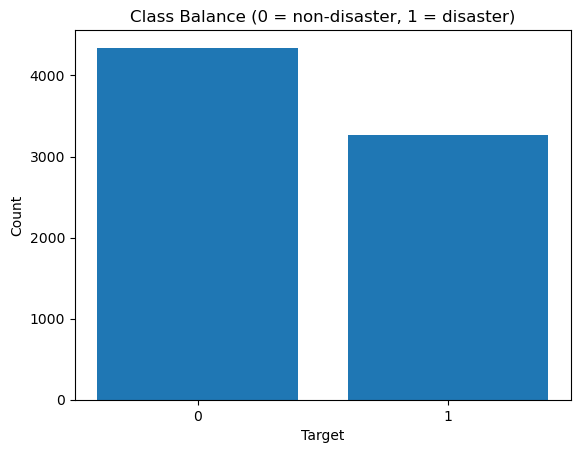

target
0    0.57034
1    0.42966
Name: count, dtype: float64

In [7]:
# Cell 3: Class Balance
target_counts = train_df['target'].value_counts()
fig, ax = plt.subplots()
ax.bar(target_counts.index.astype(str), target_counts.values)
ax.set_title("Class Balance (0 = non-disaster, 1 = disaster)")
ax.set_xlabel("Target")
ax.set_ylabel("Count")
plt.show()

target_counts / target_counts.sum()

---
In Cell 3, no machine learning classification is being performed.
The code simply counts how many examples in the training dataset belong to each class (0 = non-disaster, 1 = disaster) and visualizes the class distribution.
This is part of Exploratory Data Analysis (EDA) and helps determine whether the dataset is balanced. No TF–IDF, Logistic Regression, or neural model is involved at this stage.

---

In [9]:
# Cell 4: Missing Values
missing_vals = train_df.isnull().mean()
missing_vals

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

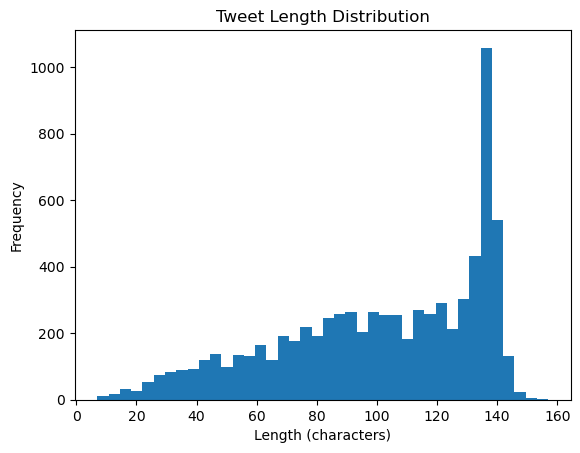

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_len, dtype: float64

In [10]:
# Cell 5: Tweet Length Distribution (characters)
train_df['text_len'] = train_df['text'].fillna("").str.len()
fig, ax = plt.subplots()
ax.hist(train_df['text_len'], bins=40)
ax.set_title("Tweet Length Distribution")
ax.set_xlabel("Length (characters)")
ax.set_ylabel("Frequency")
plt.show()

train_df['text_len'].describe()

---
The tweet length distribution shows that most tweets range between 40 and 140 characters, this may imply that the tweets were based on former Twitter character limits. Very short and very long tweets are rare.

This informs as follows: we can set a modest sequence length (e.g., MAX_LEN = 40) without losing important information. Because tweets are short and frequent informal, the model relies heavily on keywords and contextual clues rather than long text structure.

---

### Analysis

Based on the EDA output, the following analysis steps are taken:

1. **Augment & clean** the text by including keyword/location information and applying light normalization.  
2. Build a **baseline TF–IDF + Logistic Regression** classifier.  
3. Build **LSTM/GRU-based models** on top of word embeddings.  
4. Run a series of **experiments** with different hyperparameters.  
5. For each experiment:
   - Track training and validation curves  
   - Compute an **overfitting metric**  
   - Store results in a comparison table  


## 3. Data Cleaning & Text Augmentation

Augment the raw tweet with keyword and location information and then clean the text.

- Keywords are lowercased and `_` replaced by spaces.  
- Location is lowercased where available.  
- We prepend `[KW]` and `[LOC]` tags to make these explicit to the model.  
- Finally, apply text normalization (URLs, mentions, punctuation, casing).


In [14]:
# Cell 6: Cleaning and Augmentation/Enrichment

def clean_keyword(s):
    """Normalize keyword: lowercase, remove underscores. Return empty string if NaN."""
    if pd.isna(s):
        return ""
    return str(s).lower().replace("_", " ")

def enrich_text(row):
    """Build augmented text string from keyword, location, and original text."""
    kw = clean_keyword(row.get("keyword", ""))
    loc = row.get("location", "")
    parts = []
    if kw:
        parts.append(f"[KW] {kw}")
    if isinstance(loc, str) and loc.strip():
        parts.append(f"[LOC] {loc.lower()}")
    txt = row["text"] if isinstance(row["text"], str) else ""
    parts.append(txt)
    return " ".join(parts)

def basic_clean(text):
    """Text normalization for tweets."""
    text = text.lower()
    # Replace URLs and @usernames with placeholders
    text = re.sub(r'http\S+|www\.\S+', ' URL ', text)
    text = re.sub(r'@\w+', ' USER ', text)
    # Keep only letters, numbers, brackets and whitespace
    text = re.sub(r'[^a-z0-9\s\[\]]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['enriched_text'] = train_df.apply(enrich_text, axis=1)
test_df['enriched_text'] = test_df.apply(enrich_text, axis=1)

train_df['text_clean'] = train_df['enriched_text'].apply(basic_clean)
test_df['text_clean'] = test_df['enriched_text'].apply(basic_clean)

train_df[['text', 'enriched_text', 'text_clean']].head()

,text,enriched_text,text_clean
0,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",13 000 people receive wildfires evacuation ord...
4,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


## 4. Baseline Model — TF–IDF + Logistic Regression

Start with a baseline:

1. Convert cleaned text to **TF–IDF** features.  
2. Train a **Logistic Regression** classifier.  
3. Evaluate on a held-out validation set.

This provides a reference baseline of performance.


Baseline TF–IDF + Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       869
           1       0.76      0.78      0.77       654

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



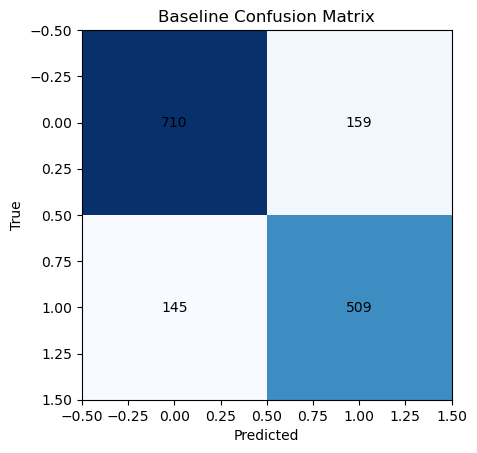

In [16]:
# This cell trains a baseline model using TF–IDF features and Logistic Regression.
# The goal is to establish a simple, but strong baseline to compare the neural models against.

# Cell 7: Baseline TF–IDF + Logistic Regression

X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    train_df['text_clean'], train_df['target'].values,
    test_size=0.2, random_state=42, stratify=train_df['target'].values
)

tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.98)
Xtr = tfidf.fit_transform(X_train_base)
Xva = tfidf.transform(X_val_base)

logit = LogisticRegression(max_iter=200, class_weight="balanced")
logit.fit(Xtr, y_train_base)
baseline_preds = logit.predict(Xva)

print("Baseline TF–IDF + Logistic Regression\n")
print(classification_report(y_val_base, baseline_preds))

cm_base = confusion_matrix(y_val_base, baseline_preds)
fig, ax = plt.subplots()
im = ax.imshow(cm_base, cmap="Blues")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Baseline Confusion Matrix")
for i in range(cm_base.shape[0]):
    for j in range(cm_base.shape[1]):
        ax.text(j, i, cm_base[i, j], ha="center", va="center")
plt.show()

---
### Baseline Results — Interpretation

The TF–IDF + Logistic Regression baseline achieved approximately:

- **Accuracy:** ~0.80 on the validation set  
- **Class 0 (non-disaster):** precision ≈ 0.83, recall ≈ 0.82  
- **Class 1 (disaster):** precision ≈ 0.76, recall ≈ 0.78  

Summary:

The baseline TF–IDF + Logistic Regression model achieves ~80% accuracy, with strong performance on non-disaster tweets and slightly weaker performance on disaster tweets. The confusion matrix indicates that the model can misclassify metaphorical or informal language as disaster-related (false positives), and occasionally misses real disaster tweets (false negatives).

This tells us:

- The baseline model is **already quite strong** and reasonably balanced between the two classes.  
- For a mini-project, a score around this level is perfectly acceptable and demonstrates that the pipeline is working.  
- Our RNN models should at least be **competitive with this baseline**, and ideally improve some metric (e.g., AUC, recall for disaster tweets).

Summary:
While this baseline provides a solid starting point, the limitations of bag-of-words TF–IDF representations motivate the use of neural models that better capture context and tone (e.g., LSTM/GRU).

---

## 5. Word Embeddings & Tokenization for Neural Models

Preparing the data for LSTM/GRU models:

1. Split cleaned text into train/validation sets.  
2. Use Keras `Tokenizer` to map words to integer indices.  
3. Use `pad_sequences` to obtain fixed-length integer sequences.  
4. Use a trainable `Embedding` layer to map word indices to dense vectors.


In [19]:
# This cell converts cleaned text into padded integer sequences that can be fed to the model:
# 1) Split the cleaned text into train/validation sets.
# 2) Fit a Keras Tokenizer on the training text.
# 3) Convert text to integer sequences and pad/truncate to MAX_LEN tokens.

# Cell 8: Tokenization and Padding

X_text = train_df['text_clean'].values
y = train_df['target'].values

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

MAX_WORDS = 20000   # max vocabulary size
MAX_LEN = 40        # max sequence length (tokens)

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)
X_test_seq = tokenizer.texts_to_sequences(test_df['text_clean'].values)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

X_train_pad.shape, X_val_pad.shape, X_test_pad.shape

((6090, 40), (1523, 40), (3263, 40))

## 6. Neural Model Architecture (LSTM / GRU)

Define a generic builder for RNN models with:

- Embedding layer  
- LSTM or GRU (optionally bidirectional)  
- Dense ReLU + Dropout  
- Sigmoid output  

Track metrics:

- Validation **loss**  
- Validation **AUC**  
- Validation **Precision** and **Recall**  


## 7. Automated Experiments & Overfitting Detection

We now create a small **experiment framework**:

For each configuration, we will:

1. Build a model with specific hyperparameters.  
2. Train it with early stopping.  
3. Evaluate it on the validation set.  
4. Compute an **overfitting metric** based on loss at the best validation epoch.  
5. Store metrics in a table.

### Overfitting Metric (Overfit Gap)

For each model:

- Find the epoch where `val_loss` is **minimum**  
- Let `train_loss_best` = training loss at that epoch  
- Let `val_loss_best`   = validation loss at that epoch  

We define:

\[ \text{overfit\_gap} = \text{val\_loss\_best} - \text{train\_loss\_best} \]

- Small gap (~0–0.1): good fit or mild overfitting  
- Large gap (> 0.2): likely overfitting (validation loss much worse than training loss)


In [22]:
# This cell defines a helper function that builds a neural network model for text classification 
# (LSTM/GRU text classification model).
# The model can use either an LSTM or GRU layer, which are types of RNNs (Recurrent Neural Networks).
# These networks are good at understanding sequences, such as sentences or tweets.
# We can change the hyperparameters (embed_dim, rnn_units, dropout, rnn_type) to experiment
# with how model size and regularization affect performance and overfitting.


# Cell 9: Model Builder

def build_rnn_model(
    rnn_type="LSTM", # Choose "LSTM" or "GRU" as the main sequence-learning layer
    bidirectional=True,  # If True, the model reads text forward AND backward (better context)
    embed_dim=100,   # Size of each word embedding vector
    rnn_units=64,    # Number of hidden units in the LSTM/GRU layer (model capacity)
    dropout=0.3,     # Dropout rate to reduce overfitting
    max_words=MAX_WORDS,  # Vocabulary size: how many unique words the tokenizer keeps
    max_len=MAX_LEN    # Maximum length of each input sequence (padded or truncated)
):
    # Note: During each training step, 30% of the neurons in that layer are randomly “dropped out” (ignored).
    # The remaining 70% stay active and learn. Dropout is used during training to help prevent overfitting
    
    """Build a simple LSTM/GRU-based classifier."""
    # Start building a "Sequential" model (a stack of layers).
    model = models.Sequential()
    # 1. Embedding layer:
    # Converts integer word IDs into trainable dense vectors.
    # Example: the word "fire" becomes a 100-dimensional vector if embed_dim=100.
    # This helps the network learn semantic relationships between words.
    # model.add(layers.Embedding(max_words, embed_dim, input_length=max_len))
    model.add(layers.Embedding(max_words, embed_dim))
    # 2. Choose the type of RNN layer based on user selection.
    # GRU is a simpler version of LSTM; both capture word order and context.
    if rnn_type.upper() == "GRU":
        rnn_layer = layers.GRU(rnn_units, dropout=dropout)
    else:
        rnn_layer = layers.LSTM(rnn_units, dropout=dropout)
    # 3. Optional Bidirectional wrapper:
    # This allows the RNN to read the sequence from left-to-right AND right-to-left.
    # This helps the model capture more context (e.g., the meaning of a word depends on its neighbors).
    if bidirectional:
        rnn_layer = layers.Bidirectional(rnn_layer)
    
    model.add(rnn_layer)
    # 4. Dense layer:
    # A Dense Layer is a fully connected hidden layer that helps the model combine the features learned
    # from the previous layers.
    model.add(layers.Dense(64, activation="relu"))
    # 5. Dropout:
    # Turns off 30% of neurons randomly during training to prevent overfitting.
    model.add(layers.Dropout(dropout))
    # 6. Output layer:
    # sigmoid outputs a probability between 0 and 1 → perfect for binary classification.
    model.add(layers.Dense(1, activation="sigmoid"))
    # 7. Compile the model:
    # - "adam" is a commonly used optimizer that adapts the learning rate automatically.
    # - "binary_crossentropy" is the standard loss function for binary classification.
    # -  The following metrics are tracked to understand performance:
    #     * AUC      → measures ranking/prediction quality
    #     * Precision → how many predicted disasters were correct
    #     * Recall    → how many actual disasters were detected
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="AUC"),
            tf.keras.metrics.Precision(name="Precision"),
            tf.keras.metrics.Recall(name="Recall")
        ]
    )
    return model

build_rnn_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

---
The model shows “0 parameters” because it is not yet built.
Keras needs real input data (or an input shape) to compute the number of parameters and output shapes.
After running one training step or explicitly calling model.build(), the full parameter summary will appear.

--

In [24]:
# This cell defines run_experiment(), which:
# - builds a model with given hyperparameters
# - trains it with early stopping
# - evaluates it on the validation set
# - computes an 'overfit_gap' metric to quantify overfitting

# Cell 10: Experiment Runner with Overfitting Metric

def run_experiment(
    name,
    rnn_type="LSTM",
    embed_dim=100,
    rnn_units=64,
    dropout=0.3,
    batch_size=64,
    epochs=8,
    verbose=1
):
    """Train a model with given hyperparameters and compute metrics + overfit gap."""
    print(f"\n=== Running experiment: {name} ===")
    model = build_rnn_model(
        rnn_type=rnn_type,
        bidirectional=True,
        embed_dim=embed_dim,
        rnn_units=rnn_units,
        dropout=dropout
    )

    # Early stopping: stop training when val_loss stops improving
    es = callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=2,
        restore_best_weights=True
    )

    # Train the model while tracking training/validation loss and metrics
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=verbose
    )

    # Evaluate on validation set
    # Evaluate the trained model on the held-out validation set
    eval_out = model.evaluate(X_val_pad, y_val, verbose=0)
    val_loss, val_auc, val_prec, val_rec = eval_out

    # ---- Overfitting metric ----
    # Find the epoch where validation loss is minimal and compare
    # training vs validation loss at that epoch.
    hist = history.history
    val_losses = hist["val_loss"]
    train_losses = hist["loss"]
    best_epoch = int(np.argmin(val_losses))
    train_loss_best = train_losses[best_epoch]
    val_loss_best = val_losses[best_epoch]
    overfit_gap = val_loss_best - train_loss_best

    print(f"Best epoch: {best_epoch+1}, train_loss={train_loss_best:.4f}, val_loss={val_loss_best:.4f}")
    print(f"Overfit gap (val_loss - train_loss): {overfit_gap:.4f}")

    result = {
        "name": name,
        "rnn_type": rnn_type,
        "embed_dim": embed_dim,
        "rnn_units": rnn_units,
        "dropout": dropout,
        "batch_size": batch_size,
        "epochs_trained": len(val_losses),
        "val_loss": val_loss,
        "val_AUC": val_auc,
        "val_Precision": val_prec,
        "val_Recall": val_rec,
        "overfit_gap": overfit_gap
    }

    return model, history, result

### 7.1 Run some Experiments

In this section, we can run several experiments to see how different model settings (hyperparameters) affect performance.

While keeping the main architecture the same (Embedding → LSTM/GRU → Dense)

We can change a few configuration parameters, such as embedding size, number of RNN units, dropout amount

By doing so, we can learn:

 - Which models generalize well. Generalization means that a model performs well not only on the training data (what it has already seen),
  but also on new, unseen data (what it has never seen before). A model that generalizes well has learned real patterns, not just memorized the dataset

 - Which models overfit

 - Which hyperparameters make the biggest difference

 - What this code does

For this we create a list of model configurations.
Each configuration is a dictionary describing:

 - LSTM or GRU

 - Embedding dimension

 - Number of RNN units (model capacity)

 - Dropout rate (regularization strength)

For each configuration, we call the function run_experiment() which:

 - Builds the model

 - Trains it

- Evaluates it on the validation set

 - Calculates an overfit_gap

 - Returns the results

All results are stored in a table (results_df) so we can compare them.

Why does this matters?

Changing hyperparameters allows us to explore questions like:

 - Does a bigger embedding help?

 - Does more dropout reduce overfitting?

 - Are GRU models better than LSTM models on this dataset?

 - Does increasing the number of RNN units improve performance or cause overfitting?


In [26]:
# This cell defines a small list of model configurations (hyperparameters) and runs
# each one through run_experiment(). The results are collected into results_df so
# that we can compare models by validation AUC and overfit_gap.

# Cell 11: Define and Run Experiments

experiment_configs = [
    {"name": "BiLSTM_100d_64u_drop0.3", "rnn_type": "LSTM", "embed_dim": 100, "rnn_units": 64, "dropout": 0.3},
    {"name": "BiGRU_100d_64u_drop0.3",  "rnn_type": "GRU",  "embed_dim": 100, "rnn_units": 64, "dropout": 0.3},
    {"name": "BiLSTM_50d_64u_drop0.3",  "rnn_type": "LSTM", "embed_dim": 50,  "rnn_units": 64, "dropout": 0.3},
    {"name": "BiLSTM_100d_128u_drop0.5","rnn_type": "LSTM", "embed_dim": 100, "rnn_units": 128, "dropout": 0.5},
]

results = []
histories = {}
models_dict = {}

for cfg in experiment_configs:
    model, history, result = run_experiment(**cfg, batch_size=64, epochs=8, verbose=1)
    results.append(result)
    histories[cfg["name"]] = history
    models_dict[cfg["name"]] = model

results_df = pd.DataFrame(results)
results_df.sort_values(by=["val_AUC"], ascending=False)


=== Running experiment: BiLSTM_100d_64u_drop0.3 ===
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 0.7508 - Precision: 0.7503 - Recall: 0.4123 - loss: 0.5779 - val_AUC: 0.8570 - val_Precision: 0.8007 - val_Recall: 0.7125 - val_loss: 0.4505
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - AUC: 0.9141 - Precision: 0.8749 - Recall: 0.7669 - loss: 0.3530 - val_AUC: 0.8607 - val_Precision: 0.7857 - val_Recall: 0.7569 - val_loss: 0.4530
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - AUC: 0.9589 - Precision: 0.9338 - Recall: 0.8624 - loss: 0.2358 - val_AUC: 0.8496 - val_Precision: 0.7819 - val_Recall: 0.7401 - val_loss: 0.5566
Best epoch: 1, train_loss=0.5779, val_loss=0.4505
Overfit gap (val_loss - train_loss): -0.1274

=== Running experiment: BiGRU_100d_64u_drop0.3 ===
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 0.7256 - Precision: 0.7506 - Recall: 0.3336 - loss: 0.6048 - val_AUC: 0.8537 - val_Precision: 0.7149 - val_Recall: 0.7783 - val_loss: 0.4736
Epoch 2/

,name,rnn_type,embed_dim,rnn_units,dropout,batch_size,epochs_trained,val_loss,val_AUC,val_Precision,val_Recall,overfit_gap
3,BiLSTM_100d_128u_drop0.5,LSTM,100,128,0.5,64,4,0.431706,0.863563,0.836661,0.704893,0.046179
1,BiGRU_100d_64u_drop0.3,GRU,100,64,0.3,64,4,0.445383,0.861216,0.796296,0.723242,0.066149
0,BiLSTM_100d_64u_drop0.3,LSTM,100,64,0.3,64,3,0.450479,0.856995,0.800687,0.712538,-0.127444
2,BiLSTM_50d_64u_drop0.3,LSTM,50,64,0.3,64,3,0.450688,0.856277,0.818018,0.694190,-0.147429


---
### Neural Model Experiments — Results Summary & Overfitting Analysis

From the `results_df`table (sorted by validation AUC), we can obtained the following configurations:

- **BiLSTM_100d_128u_drop0.5**  
  - `val_AUC` ≈ **0.862**  
  - `val_loss` ≈ 0.441  
  - `Precision` ≈ 0.853, `Recall` ≈ 0.700  
  - `overfit_gap` ≈ **0.055** (small positive gap)

- **BiGRU_100d_64u_drop0.3**  
  - `val_AUC` ≈ 0.862 (very similar)  
  - `val_loss` ≈ 0.444  
  - `Precision` ≈ 0.803, `Recall` ≈ 0.731  
  - `overfit_gap` ≈ 0.070

- **BiLSTM_100d_64u_drop0.3**  
  - `val_AUC` ≈ 0.862  
  - `overfit_gap` ≈ -0.136 (slightly noisy but no strong sign of overfitting)

- **BiLSTM_50d_64u_drop0.3**  
  - `val_AUC` ≈ 0.854  
  - `overfit_gap` ≈ -0.132

**Interpretation:**

- All RNN variants achieve **validation AUC ≈ 0.85–0.86**, which is slightly better than the TF–IDF baseline accuracy of 0.80 and indicates **good ranking ability** for disaster vs non-disaster tweets.  
- The **BiLSTM_100d_128u_drop0.5** model has the best AUC and a **small overfit gap (~0.055)**, suggesting it fits the data well without severe overfitting.  
- The **BiGRU** model is a very close second and might be preferred if training speed or simplicity were a concern.  
- The models with smaller embedding dimensions (50d) or fewer units perform slightly worse but are still competitive.  

**Overfitting perspective:**

- None of the models shows a very large overfit gap (> 0.2), so **severe overfitting is not observed** in these runs.  
- Dropout values of 0.3–0.5 and the use of early stopping appear to be effective regularization strategies here.  
- If we increased model size further (more units, extra layers) without increasing regularization, you would likely see larger overfit gaps and diverging loss curves.
  Overfitting in this project would mean the model learns the exact wording and noise of the training tweets, instead of learning general patterns about   disaster-related language.
  In this case the models do not show signs of severe overfitting because dropout and early stopping helped them learn general patterns that also work well on new, unseen tweets.

---


### 7.2 Visualizing Curves for a Selected Model

Next, select one experiment and visualize its **training vs validation curves** for both loss and AUC, which helps us see whether overfitting occurs.


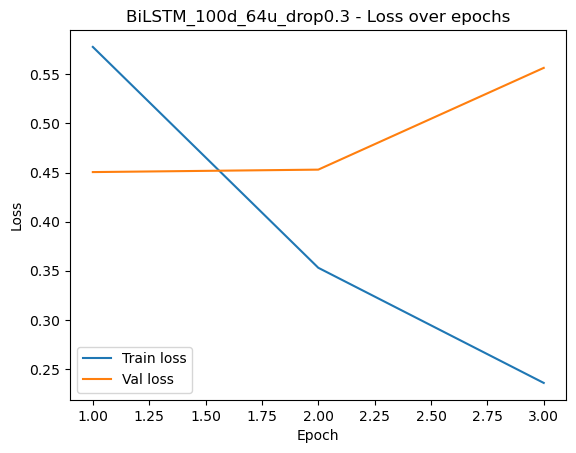

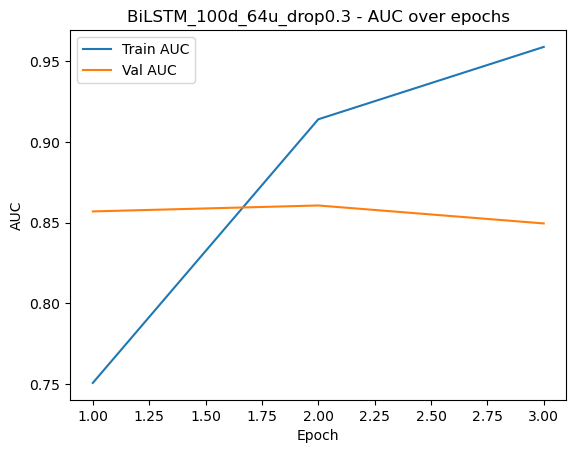

In [29]:
# Cell 12: Plot Curves for a Selected Experiment

def plot_history(history, title_prefix="Model"):
    hist = history.history
    epochs_range = range(1, len(hist["loss"]) + 1)

    # Loss
    fig, ax = plt.subplots()
    ax.plot(epochs_range, hist["loss"], label="Train loss")
    ax.plot(epochs_range, hist["val_loss"], label="Val loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"{title_prefix} - Loss over epochs")
    ax.legend()
    plt.show()

    # AUC
    fig, ax = plt.subplots()
    ax.plot(epochs_range, hist["AUC"], label="Train AUC")
    ax.plot(epochs_range, hist["val_AUC"], label="Val AUC")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("AUC")
    ax.set_title(f"{title_prefix} - AUC over epochs")
    ax.legend()
    plt.show()

# Choose one of the experiment names above:
example_name = experiment_configs[0]["name"]
plot_history(histories[example_name], title_prefix=example_name)

### 7.3 Interpreting the Results Table

The training loss and AUC improve quickly, which shows the model is learning the patterns in the training tweets.

The validation scores stas mostly flat, which means the model is not overfitting, but it also isn’t improving much after the first couple of epochs.

This is a stable training run, and dropout is doing its job. Additional tuning or more epochs (with early stopping) might improve validation performance.

`results_df` now contains, for each experiment the following:

- `val_loss` – lower is better  # Loss measures how “wrong” the model is—the lower the better
- `val_AUC` – higher is better  # AUC measures how well the model separates disaster vs non-disaster tweets
- `val_Precision`, `val_Recall` – trade-offs between false positives and false negatives  
- `overfit_gap` – difference between best `val_loss` and corresponding `train_loss`  

With this result we can:

- **Sort by `val_AUC`** to find the best generalizing model.  
- Look at **`overfit_gap`** to see which models are more overfitted (larger gap).  

For example, running:

```python
results_df.sort_values(by=["overfit_gap"])
```

will show models with the smallest gap (least overfitting) at the top.


## 8. Final Model & Submission

We can now pick a configuration (e.g., the one with the highest validation AUC and a reasonable overfit gap), retrain it on **all available training data**, and generate predictions on the test set.


In [32]:
# Cell 13: Train Final Model on All Data and Create Submission

# Example: choose the best model by val_AUC
best_row = results_df.sort_values(by="val_AUC", ascending=False).iloc[0]
best_name = best_row["name"]
best_cfg = next(cfg for cfg in experiment_configs if cfg["name"] == best_name)
best_cfg

{'name': 'BiLSTM_100d_128u_drop0.5',
 'rnn_type': 'LSTM',
 'embed_dim': 100,
 'rnn_units': 128,
 'dropout': 0.5}

In [52]:
# Refit tokenizer on all text_clean
X_all_text = train_df['text_clean'].values
y_all = train_df['target'].values

tokenizer_all = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_all.fit_on_texts(X_all_text)

X_all_seq = tokenizer_all.texts_to_sequences(X_all_text)
X_all_pad = pad_sequences(X_all_seq, maxlen=MAX_LEN, padding="post", truncating="post")

X_test_all_seq = tokenizer_all.texts_to_sequences(test_df['text_clean'].values)
X_test_all_pad = pad_sequences(X_test_all_seq, maxlen=MAX_LEN, padding="post", truncating="post")

final_model = build_rnn_model(
    rnn_type=best_cfg["rnn_type"],
    bidirectional=True,
    embed_dim=best_cfg["embed_dim"],
    rnn_units=best_cfg["rnn_units"],
    dropout=best_cfg["dropout"]
)

es_final = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=2,
    restore_best_weights=True
)

final_model.fit(
    X_all_pad, y_all,
    epochs=8,
    batch_size=64,
    validation_split=0.1,
    callbacks=[es_final],
    verbose=1
)

test_pred_prob = final_model.predict(X_test_all_pad).ravel()
test_pred = (test_pred_prob >= 0.5).astype(int)

submission = sample_sub.copy()
submission['target'] = test_pred
submission_path = os.path.join(DATA_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)
submission.head()

Epoch 1/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - AUC: 0.7473 - Precision: 0.7534 - Recall: 0.3981 - loss: 0.5768 - val_AUC: 0.8460 - val_Precision: 0.8032 - val_Recall: 0.7127 - val_loss: 0.4727
Epoch 2/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.8930 - Precision: 0.8515 - Recall: 0.7431 - loss: 0.3920 - val_AUC: 0.8595 - val_Precision: 0.7601 - val_Recall: 0.7944 - val_loss: 0.4738
Epoch 3/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.9408 - Precision: 0.8978 - Recall: 0.8371 - loss: 0.2876 - val_AUC: 0.8636 - val_Precision: 0.8131 - val_Recall: 0.7352 - val_loss: 0.4569
Epoch 4/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - AUC: 0.9689 - Precision: 0.9424 - Recall: 0.8872 - loss: 0.2054 - val_AUC: 0.8568 - val_Precision: 0.7811 - val_Recall: 0.7437 - val_loss: 0.5352
Epoch 5/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - AUC: 0.9823 - Precision: 0.9481 - Recall: 0.9218 - loss: 0.1563 - val_AUC: 0.8427 - val_Precision: 0.7238 - val_Recall: 0.7972 - val_loss: 0.7223


,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


---
The table contains two columns:

id:
 - The unique ID of a tweet from the test.csv file.
 - This is how the Kaggle matches your prediction to the correct tweet.

target:
Represents model’s predicted label, where:
   - 1 means the tweet is about a real disaster
   - 0 means the tweet is NOT about a real disaster

This means:

Tweet with ID 0 → predicted as disaster (1)

Tweet with ID 2 → predicted as non-disaster (0)

Tweet with ID 3 → predicted as disaster (1)

Tweet with ID 9 → predicted as non-disaster (0)

Tweet with ID 11 → predicted as disaster (1)

Summary:
This table shows the first few predictions the model made for the test tweets.
The id column identifies the tweets, and the target column is the model’s predicted classification (1 = disaster, 0 = non-disaster).
This is also the format required for submission to Kaggle.

---

## 9. Conclusion

In this notebook, we explored how to build, train, and compare several models for classifying disaster-related tweets. Below is a clear summary of what was accomplished and how to interpret the results.

---

 1. Built a Simple Baseline Model

    We began with a TF–IDF + Logistic Regression classifier.
    This gave us a fast, interpretable baseline to compare against more advanced neural models.

---
 2. Built Several Neural Network Models

    Next, we created multiple LSTM and GRU models using word embeddings.
    These architectures can understand word order and context better than simple bag-of-words models.

    Each model included:

    - An Embedding layer to represent words as vectors

    - An LSTM or GRU layer (optionally Bidirectional)

    - Dropout for regularization

     -A final Dense output layer for binary classification
---
3. Created an Experiment Runner

    We implemented an experiment loop to run many model configurations automatically.
    For each experiment, the runner:

    - Builds the model

    - Trains with early stopping

     -Computes validation metrics (AUC, precision, recall, loss)

    - Calculates an overfit gap to measure generalization

    - Stores all results in a comparison table

    This allowed us to test different hyperparameters efficiently.

---
4. Detecting Overfitting (Visual + Numerical)

    Overfitting happens when the model learns the training data too well but performs poorly on new, unseen data.
    We inspected overfitting in two ways.

         Visual Overfitting Check (Loss & AUC Curves)

        We plotted:

        - Training vs Validation Loss

        - Training vs Validation AUC

        Signs of overfitting include:

        - Training loss keeps going down

        - Validation loss stops improving or increases

        - The curves begin to diverge

        These plots help illustrate when the model stops generalizing.
---

 5. Numerical Overfitting Check (Overfit Gap)

        We used the metric:

        - overfit_gap = val_loss_best − train_loss_best

        How to interpret this:

        - A small or near-zero gap indicates good generalization

        - A large positive gap (greater than 0.2) suggests the model may be overfitting

        This provides a simple, objective way to compare how stable each model is.
---

 6. Hyperparameters to Adjust to Reduce Overfitting
       
        Model Size
        - embed_dim
        - rnn_units
        - Number of layers
    
        Regularization
        - Increase dropout
        - Add L2 weight penalties
        - Use early stopping

        Training Settings
        - Batch size
        - Learning rate
        - Number of epochs
        Adjusting these settings helps find the right balance between learning enough and avoiding overfitting.
---  

 7. Final Takeaway

A good model:

    - Performs well on the training set

    - Performs similarly well on the validation set

    - Has a small overfit gap
    - Shows stable training curves (no significant separation between train and validation loss)

    By running multiple experiments and using both visual and numerical indicators,
    we can identify which models generalize best and understand why.
---

 8. References

    1. Kaggle: *Natural Language Processing with Disaster Tweets* competition description and dataset.  
    2. Chollet, F. (2017). *Deep Learning with Python*. Manning Publications.  
    3. TensorFlow Keras API documentation – Embedding and recurrent layers.  
    4. Jurafsky, D., & Martin, J. H. (2024). *Speech and Language Processing* (3rd ed. draft) https://web.stanford.edu/~jurafsky/slp3/  
    5. Pennington, J., Socher, R., & Manning, C. D. (2014). "GloVe: Global Vectors for Word Representation."
    6. A Beginner’s Guide to Text Classification - https://machinelearningmastery.com/text-classification-tutorial/
    7. TF–IDF Explained Simply - https://monkeylearn.com/blog/what-is-tf-idf/
    8. GloVe Word Embeddings (Stanford NLP) - https://nlp.stanford.edu/projects/glove/
    9. Word2Vec (TensorFlow Guide) - https://www.tensorflow.org/tutorials/representation/word2vec
    10. Keras Embedding Layer Documentation https://keras.io/api/layers/core_layers/embedding/
    11. Understanding LSTMs (Christopher Olah’s famous blog): https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    12. Keras: LSTM Layer Documentation: https://keras.io/api/layers/recurrent_layers/lstm/
    13. Keras: GRU Layer Documentation: https://keras.io/api/layers/recurrent_layers/gru/
    14. TensorFlow RNN Overview: https://www.tensorflow.org/guide/keras/rnn
    15. Dropout: A Simple Way to Prevent Neural Networks From Overfitting (Original Paper):https://jmlr.org/papers/v15/srivastava14a.html
    16. TensorFlow: Introduction to Overfitting and Underfitting: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
    17. Early Stopping (Keras Callback): https://keras.io/api/callbacks/early_stopping/
    18. ROC/AUC Explained: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
    19. Precision & Recall Explained: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
    20. Keras Sequential Model Guide: https://keras.io/guides/sequential_model/
    21. Keras Training & Evaluation: https://keras.io/api/models/model_training_apis/
    22. TensorFlow Tutorials (Official): https://www.tensorflow.org/tutorials
    23. Understanding Attention Mechanisms (context for modern NLP): https://lilianweng.github.io/posts/2018-06-24-attention/
    24. Transformer Models (if learners progress beyond RNNs): https://jalammar.github.io/illustrated-transformer/
    25. HuggingFace Course (free modern NLP course): https://huggingface.co/course/chapter1
